<a href="https://colab.research.google.com/github/Daimond92/TelecomX2-data-science/blob/develop/Telecom_X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis y Modelado de Cancelación de Clientes

Este notebook busca identificar los factores que influyen en la cancelación y construir modelos predictivos para anticiparla.

## 📚 Importación de Librerías

In [73]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y métricas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# SMOTE para balanceo
from imblearn.over_sampling import SMOTE

# Configuración de gráficos
sns.set(style="whitegrid")

#Evitar warnings
import warnings
warnings.filterwarnings('ignore')

## 📌 Extracción y Preparación de Datos

In [74]:
# Leer el archivo CSV directamente desde la URL
url = "https://raw.githubusercontent.com/Daimond92/TelecomX2-data-science/refs/heads/develop/Data/Telecom_X.csv"
df = pd.read_csv(url)

# Mostrar las primeras filas del DataFrame
df.head()

,ID_Cliente,Evasion,Genero,Es_Senior,¿Cliente con pareja?,¿Cliente con dependientes?,Tiempo_con_la_empresa,¿Servicio_Telefono?,¿Varias_Lineas_Telefono?,Servicio_Internet,...,¿Proteccion_Dispositivos?,¿Soporte_Tecnico_Internet?,¿TV_Streaming?,¿Peliculas_Streaming?,Tipo_Contrato,¿Factura_Electronica?,Metodo_Pago,Facturacion_Mensual,Facturacion_Total,Cuentas_Diarias
0,2,0.0,0,0,1,1,9,1,0,0,...,0,1,1,0,1,1,1,65.6,593.30,2.186667
1,3,0.0,1,0,0,0,9,1,1,0,...,0,0,0,1,0,0,1,59.9,542.40,1.996667
2,4,1.0,1,0,0,0,4,1,0,1,...,1,0,0,0,0,1,0,73.9,280.85,2.463333
3,11,1.0,1,1,1,0,13,1,0,1,...,1,0,1,1,0,1,0,98.0,1237.85,3.266667
4,13,1.0,0,1,1,0,3,1,0,1,...,0,1,1,0,0,1,1,83.9,267.40,2.796667


## 🔍 Análisis Exploratorio

### Preprocesamiento y Limpieza

Se realiza la revisión de datos faltantes, codificación de variables categóricas y balanceo de clases con SMOTE.


In [84]:
# Revisar datos faltantes
print(df.isnull().sum())

# Opcional: eliminar filas o imputar valores si hay NaN (ajustar según datos)
df = df.dropna()

# Convertir variables categóricas a dummies (one hot encoding)
df_encoded = pd.get_dummies(df, drop_first=True)

ID_Cliente                     0
Evasion                        0
Genero                         0
Es_Senior                      0
¿Cliente con pareja?           0
¿Cliente con dependientes?     0
Tiempo_con_la_empresa          0
¿Servicio_Telefono?            0
¿Varias_Lineas_Telefono?       0
Servicio_Internet              0
¿Seguridad_Online?             0
¿Copia_de_Seguridad_Online?    0
¿Proteccion_Dispositivos?      0
¿Soporte_Tecnico_Internet?     0
¿TV_Streaming?                 0
¿Peliculas_Streaming?          0
Tipo_Contrato                  0
¿Factura_Electronica?          0
Metodo_Pago                    0
Facturacion_Mensual            0
Facturacion_Total              0
Cuentas_Diarias                0
dtype: int64


### Análisis Exploratorio de Variables

Exploramos la correlación entre variables y la variable objetivo 'Evasion', así como visualizamos relaciones clave mediante gráficos.


In [85]:
# Matriz de correlación con variable objetivo
corr_matrix = df_encoded.corr()
target_corr = corr_matrix['Evasion'].sort_values(key=abs, ascending=False)

print("Correlaciones con Evasion:\n", target_corr)


Correlaciones con Evasion:
 Evasion                        1.000000
Tipo_Contrato                 -0.396150
Tiempo_con_la_empresa         -0.354049
Metodo_Pago                   -0.262918
Facturacion_Total             -0.199484
Cuentas_Diarias                0.192858
Facturacion_Mensual            0.192858
¿Factura_Electronica?          0.191454
¿Seguridad_Online?            -0.171270
¿Soporte_Tecnico_Internet?    -0.164716
¿Cliente con dependientes?    -0.163128
Es_Senior                      0.150541
¿Cliente con pareja?          -0.149982
¿Copia_de_Seguridad_Online?   -0.082307
¿Proteccion_Dispositivos?     -0.066193
¿TV_Streaming?                 0.063254
¿Peliculas_Streaming?          0.060860
Servicio_Internet             -0.047097
¿Varias_Lineas_Telefono?       0.040033
ID_Cliente                    -0.017779
¿Servicio_Telefono?            0.011691
Genero                        -0.008545
Name: Evasion, dtype: float64


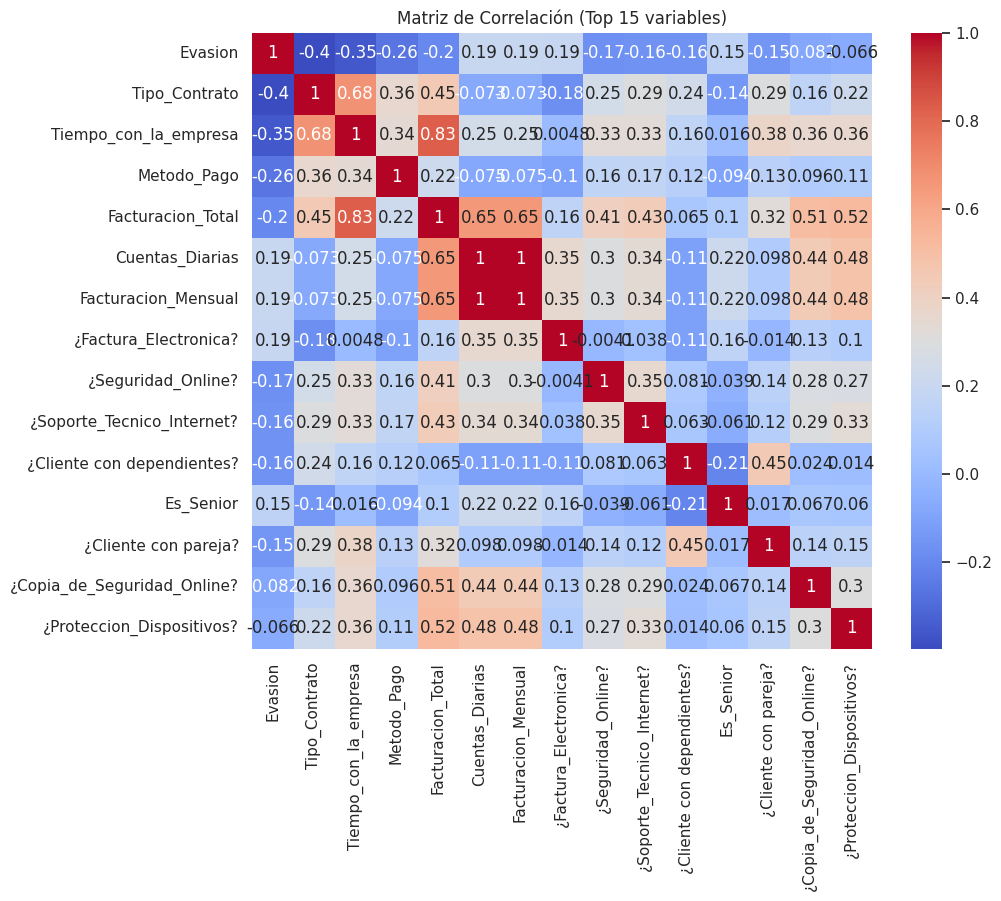

In [86]:
# Visualizar correlación con heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[target_corr.index[:15]].loc[target_corr.index[:15]], annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación (Top 15 variables)')
plt.show()

### División del Dataset

Se divide el dataset balanceado y escalado en entrenamiento y prueba, manteniendo la proporción de clases.

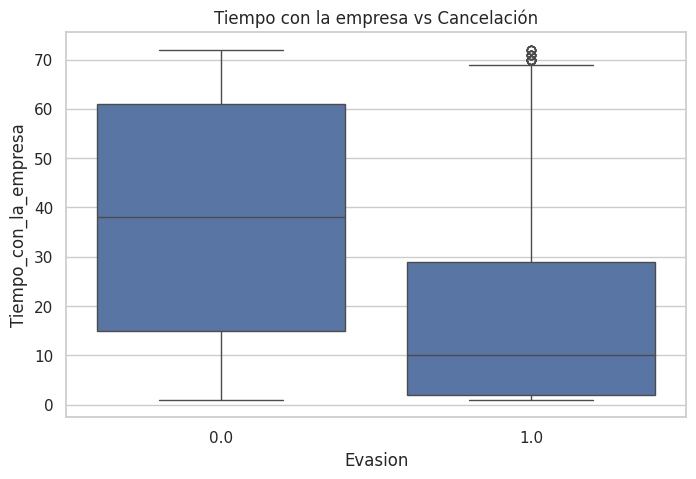

In [87]:
# Boxplot para Tiempo_con_la_empresa
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Evasion'], y=df['Tiempo_con_la_empresa'])
plt.title('Tiempo con la empresa vs Cancelación')
plt.show()

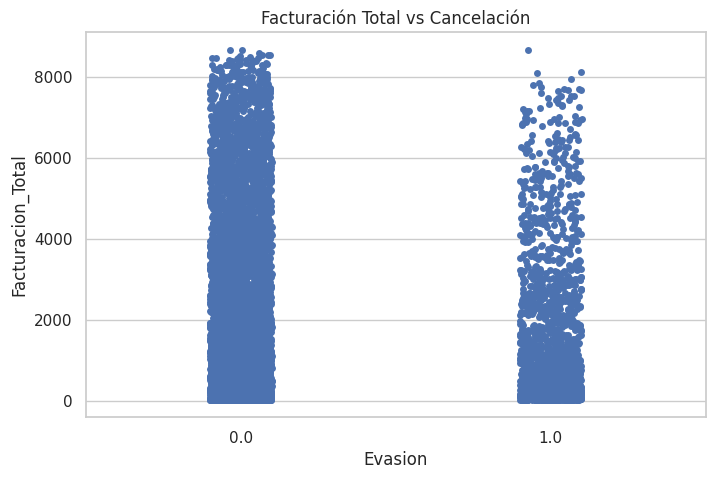

In [88]:
# Scatter plot Facturacion_Total vs Evasion (jitter para visualización)
plt.figure(figsize=(8,5))
sns.stripplot(x=df['Evasion'], y=df['Facturacion_Total'], jitter=True)
plt.title('Facturación Total vs Cancelación')
plt.show()

## 🧠 Modelado y Evaluación

### División del Dataset

Se divide el dataset balanceado y escalado en entrenamiento y prueba, manteniendo la proporción de clases.


In [89]:
# Separar X e y
X = df_encoded.drop('Evasion', axis=1)
y = df_encoded['Evasion']

# 1. Dividir los datos ANTES de aplicar SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# 2. Aplicar SMOTE SOLO al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 3. Escalar datos SOLO después de SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# 4. (Opcional) Convertir a DataFrame escalado si lo necesitas
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# 5. Revisar
print(f"Tamaño entrenamiento: {X_train_scaled_df.shape[0]} muestras")
print(f"Tamaño prueba: {X_test_scaled_df.shape[0]} muestras")

print("\nProporción clases en entrenamiento:")
print(y_train_smote.value_counts(normalize=True))

print("\nProporción clases en prueba:")
print(y_test.value_counts(normalize=True))

Tamaño entrenamiento: 8260 muestras
Tamaño prueba: 1407 muestras

Proporción clases en entrenamiento:
Evasion
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64

Proporción clases en prueba:
Evasion
0.0    0.734186
1.0    0.265814
Name: proportion, dtype: float64


### Entrenamiento y Evaluación de Modelos

Se entrenan cinco modelos diferentes y se evalúan con métricas clave para comparar desempeño.

In [90]:
def evaluar_modelo(modelo, X_train, X_test, y_train, y_test, nombre_modelo="Modelo"):
    # Entrenamiento
    modelo.fit(X_train, y_train)

    # Predicción
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]

    # Reporte
    print(f"\n📈 {nombre_modelo}")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Canceló", "Canceló"])
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

#### Modelo Regresión lineal


📈 Regresión Logística
              precision    recall  f1-score   support

         0.0       0.87      0.78      0.82      1033
         1.0       0.53      0.68      0.59       374

    accuracy                           0.75      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.75      0.76      1407

ROC AUC: 0.820


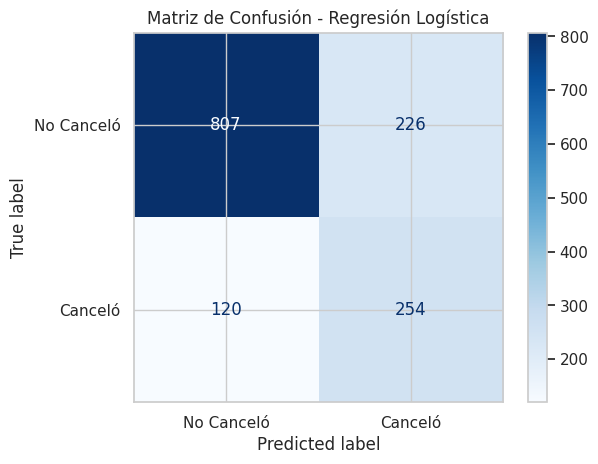

In [92]:
modelo_lr = LogisticRegression(random_state=42, max_iter=1000)
evaluar_modelo(modelo_lr, X_train_scaled, X_test_scaled, y_train_smote, y_test, "Regresión Logística")

#### Modelo Clasificación - Random Forest


📈 Random Forest
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87      1033
         1.0       0.65      0.48      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407

ROC AUC: 0.835


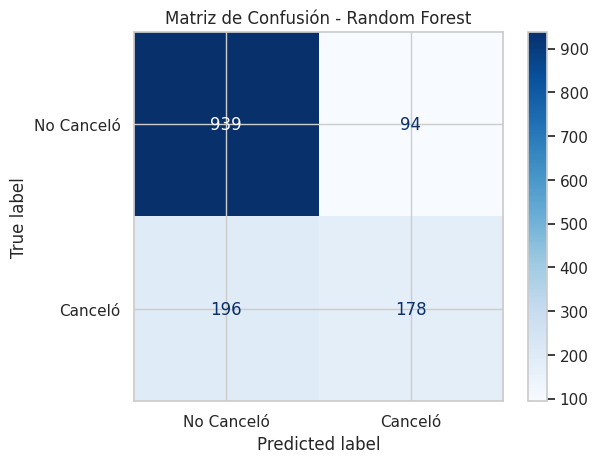

In [93]:
modelo_rf = RandomForestClassifier(random_state=42)
evaluar_modelo(modelo_rf, X_train, X_test, y_train, y_test, "Random Forest")

#### Modelo Gradient Boosting


📈 Gradient Boosting
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87      1033
         1.0       0.66      0.50      0.57       374

    accuracy                           0.80      1407
   macro avg       0.75      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407

ROC AUC: 0.848


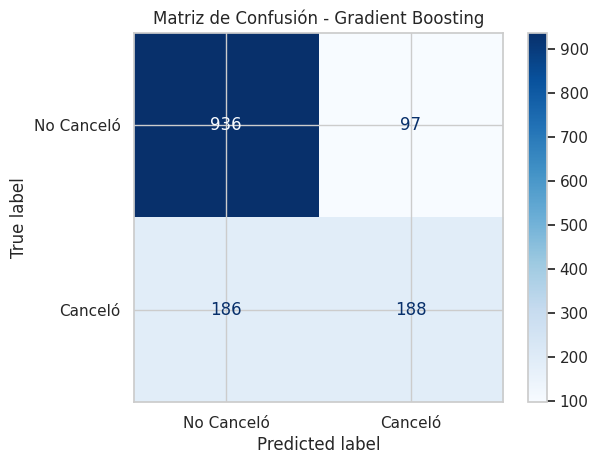

In [94]:
modelo_gb = GradientBoostingClassifier(random_state=42)
evaluar_modelo(modelo_gb, X_train, X_test, y_train, y_test, "Gradient Boosting")

#### Modelo XGBoost


📈 XGBoost
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      1033
         1.0       0.61      0.49      0.55       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407

ROC AUC: 0.819


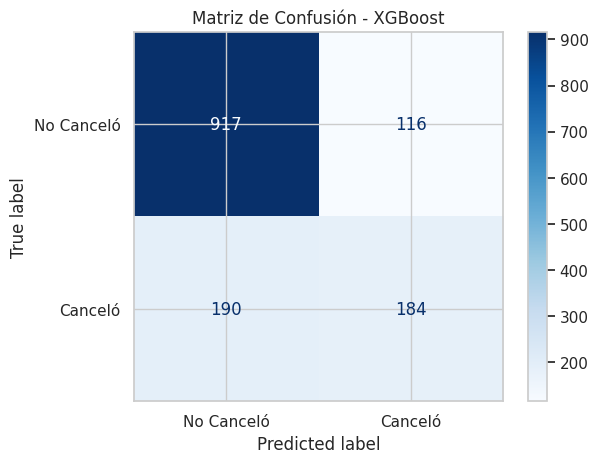

In [95]:
modelo_xgb = XGBClassifier(random_state=42, eval_metric='logloss')
evaluar_modelo(modelo_xgb, X_train, X_test, y_train, y_test, "XGBoost")

#### Modelo Árbol de Decisión


📈 Árbol de Decisión
              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85      1033
         1.0       0.59      0.52      0.55       374

    accuracy                           0.78      1407
   macro avg       0.71      0.70      0.70      1407
weighted avg       0.77      0.78      0.77      1407

ROC AUC: 0.827


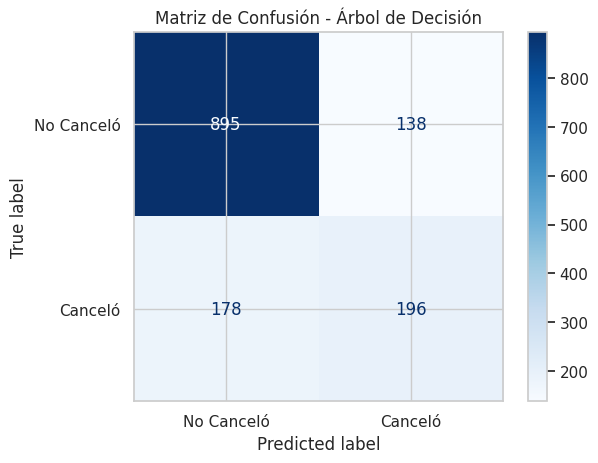

In [96]:
modelo_tree = DecisionTreeClassifier(random_state=42, max_depth=5)
evaluar_modelo(modelo_tree, X_train, X_test, y_train, y_test, "Árbol de Decisión")


📈 Árbol de Decisión
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1549
           1       0.68      0.41      0.51       561

    accuracy                           0.79      2110
   macro avg       0.75      0.67      0.69      2110
weighted avg       0.78      0.79      0.77      2110

ROC AUC: 0.822


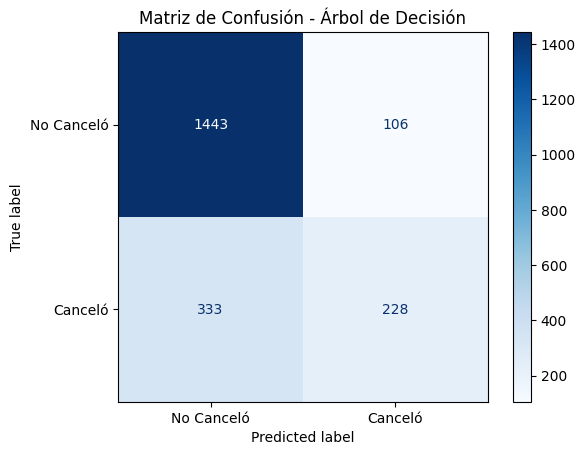

In [63]:
modelo_tree = DecisionTreeClassifier(random_state=42, max_depth=5)
evaluar_modelo(modelo_tree, X_train, X_test, y_train, y_test, "Árbol de Decisión")

## 📊 Análisis de Importancia de Variables

Se identifican las variables que más influyen en cada modelo para comprender los factores clave detrás de la cancelación.


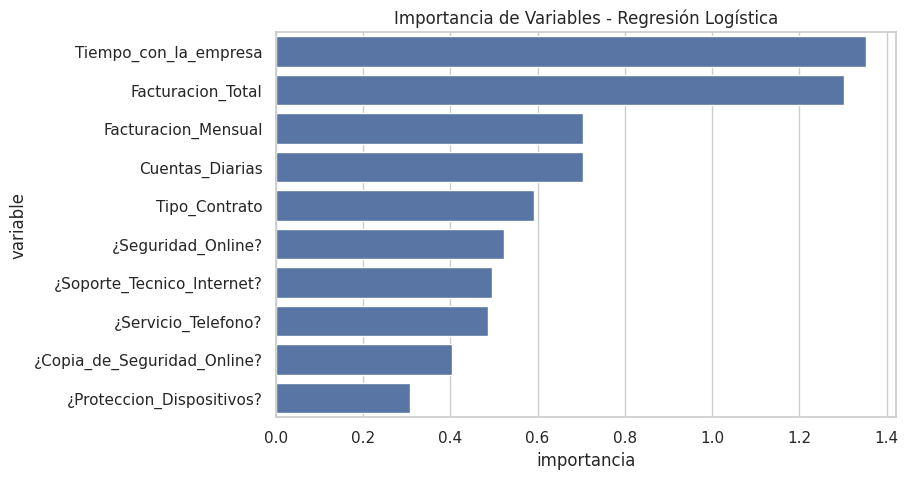

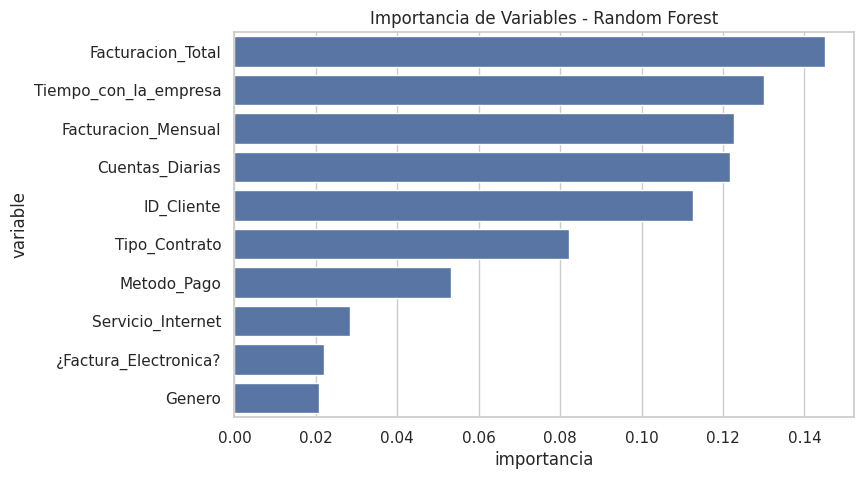

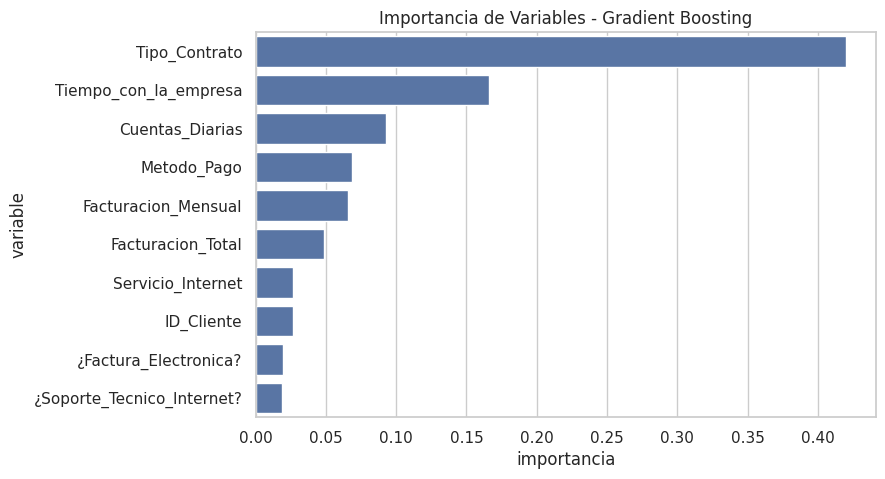

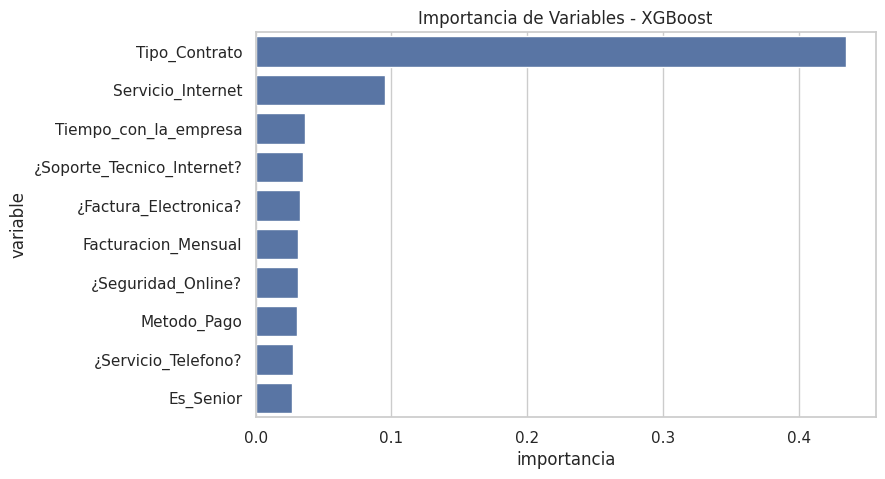

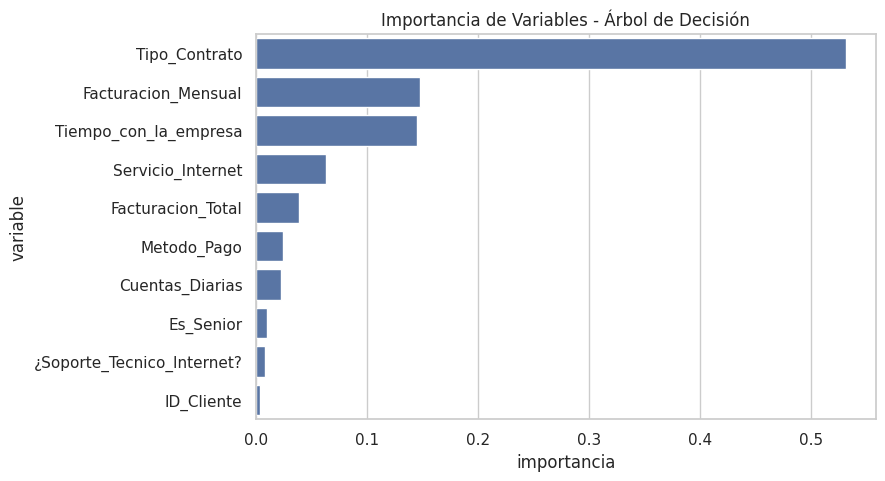

In [98]:
def plot_importancia(modelo, X_train, top_n=10, nombre_modelo='Modelo'):
    if hasattr(modelo, 'coef_'):
        # Para regresión logística y SVM lineal
        importancia = modelo.coef_[0]
    elif hasattr(modelo, 'feature_importances_'):
        # Para árboles y boosting
        importancia = modelo.feature_importances_
    else:
        print(f"No se puede obtener importancia para {nombre_modelo}")
        return

    importancia_df = pd.DataFrame({
        'variable': X_train.columns,
        'importancia': importancia
    })
    importancia_df['importancia'] = importancia_df['importancia'].abs()
    importancia_df = importancia_df.sort_values(by='importancia', ascending=False).head(top_n)

    plt.figure(figsize=(8,5))
    sns.barplot(x='importancia', y='variable', data=importancia_df)
    plt.title(f'Importancia de Variables - {nombre_modelo}')
    plt.show()

# Mostrar importancia de variables para los modelos
plot_importancia(modelo_lr, X_train, nombre_modelo='Regresión Logística')
plot_importancia(modelo_rf, X_train, nombre_modelo='Random Forest')
plot_importancia(modelo_gb, X_train, nombre_modelo='Gradient Boosting')
plot_importancia(modelo_xgb, X_train, nombre_modelo='XGBoost')
plot_importancia(modelo_tree, X_train, nombre_modelo='Árbol de Decisión')


#📄Informe final Telecom

## Informe Final: Análisis y Estrategias para la Cancelación de Clientes

### 1. Modelos evaluados y desempeño

Se entrenaron cinco modelos diferentes para predecir la cancelación de clientes (Evasion):  
- Regresión Logística  
- Random Forest  
- Gradient Boosting  
- XGBoost  
- Árbol de Decisión  

Los modelos de Gradient Boosting y Regresión Logística mostraron mejor desempeño, con valores de ROC AUC superiores a 0.83, buen equilibrio entre precisión y recall, lo que indica un balance aceptable entre detectar cancelaciones y evitar falsos positivos.

### 2. Variables más relevantes

Las variables que más influyen en la cancelación, según los modelos, son:  
- **Tiempo con la empresa:** menor tiempo se asocia a mayor cancelación.  
- **Tipo de servicio de Internet:** ciertos tipos están relacionados con mayor retención.  
- **Facturación mensual y total:** clientes con facturación más baja tienen mayor tendencia a cancelar.  
- **Contrato:** clientes con contratos a largo plazo tienden a cancelar menos.  
- **Soporte técnico y servicios adicionales:** servicios relacionados con seguridad online y soporte técnico tienen impacto positivo en la retención.

### 3. Estrategias de retención recomendadas

Basado en el análisis, proponemos:  
- **Incentivar contratos a largo plazo** ofreciendo descuentos o beneficios para fidelizar clientes jóvenes o con menor tiempo en la empresa.  
- **Mejorar la oferta de servicios de internet y soporte técnico,** enfocándose en la calidad y valor agregado para aumentar la satisfacción.  
- **Atención personalizada a clientes con baja facturación mensual**, diseñando promociones específicas para